In [1]:
import pandas as pd
import numpy as np

In [6]:
df_rarenote = pd.read_csv("./csv/reviews.csv")
df_rarenote.head()

,_id,co_date,co_review
0,65debc4d10cac7425905e881,2020년 2월 6일,"희귀 질환에 대한 정보나 관리가 어려워하시는 분들도 많으신데, 이런 어플은 정말 도..."
1,65debc5610cac7425905e883,2020년 2월 9일,디자인이 심플하고 직관적이라서 좋아요. 희귀질환에 대해 잘 모르고 있던 사람도 관심...
2,65debc5f10cac7425905e885,2023년 10월 23일,멜라스증후군에 대해서 공부하며 최근 이 앱을 알게된 학생입니다. 이 앱은 개인의 노...
3,65debc6510cac7425905e887,2021년 7월 13일,어려운 사용자를 위해 글씨크기도 크게 해주셨네요. 감사해요. 가끔 공지들 뜨면서 질...
4,65debc6c10cac7425905e889,2020년 2월 5일,"아무래도 희귀질환이다보니 환자분들이 최신 의학 소식을 접하기가 어려우실텐데, 본인에..."


In [7]:
df_rarenote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        178 non-null    object
 1   co_date    178 non-null    object
 2   co_review  178 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB


### 가설 : 고객들은 학술정보를 담은 내용을 원한다

In [292]:
# 불용어 리스트 생성 (예시)
stopwords = ['증후군', '관심' '희귀질환', '희귀', '희귀질환', '가지','진짜', '노트', '도움', '정말', '대해', '대한', '되다', '하다', '되어다', '자다', '받다', '감사', '어플', '아주','통해', '디자인', '이제', '평소', '사람']
from konlpy.tag import Okt

# Okt 형태소 분석기 인스턴스 생성
okt = Okt()

# 토크나이징 함수 정의
def tokenizer(raw, pos=["Noun"], stopword=stopwords):
    return [
        word for word, tag in okt.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅏ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword

    ]

In [293]:
#tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(tokenizer=tokenizer, max_df=0.95, min_df=2)

In [294]:
features = tfidfVectorizer.fit_transform(df_rarenote["co_review"])

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### 군집

In [295]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation

In [296]:
components_3  = LatentDirichletAllocation(n_components=3, n_jobs=-1) # n_components => topic 가짓수 결정 / n_jobs =>성능높이기
components_3.fit(features)

LatentDirichletAllocation(n_components=3, n_jobs=-1)

In [297]:
dictionary_list = tfidfVectorizer.get_feature_names_out(features)
dictionary_list

array(['가능성', '가입', '가장', '가족', '개발', '개선', '개인', '건강', '검사', '결과', '고생',
       '고통', '공유', '관련', '관리', '관심', '구성', '기능', '기대', '기분', '기타', '난치병',
       '내용', '노력', '누구', '다시', '다음', '당사자', '대상', '더욱', '데이터', '등록',
       '루푸스', '매우', '발전', '번역', '보고', '보기', '부분', '사용', '사용자', '상세', '생각',
       '서로', '서비스', '선택', '소식', '스케', '신약', '심플', '아이디어', '업계', '업데이트',
       '여러', '우리', '위해', '유전자', '응원', '의료', '의학', '이용', '이용자', '이프', '일단',
       '자료', '자체', '적극', '접근', '정리', '정보', '제공', '좀더', '종류', '종사', '주변',
       '줄기', '지금', '지속', '질병', '질환', '찾기', '최신', '추가', '추천', '출시', '취지',
       '치료', '컨텐츠', '크게', '파킨슨병', '포함', '항목', '항상', '해결', '해당', '해주시',
       '화이팅', '확대', '확인', '환자', '황반변성', '회원', '휴먼', '희망', '희망이'],
      dtype=object)

In [298]:
topics_output = components_3.transform(features)
df_topics_review = pd.DataFrame(data=topics_output)

In [299]:
df_topics_review['topic_num'] = np.argmax(topics_output, axis=1)
df_topics_review['review'] = df_rarenote['co_review']

In [300]:
pd.set_option('display.max_colwidth', None)
print(df_topics_review[21:22])

           0         1       2  topic_num  \
21  0.122966  0.747634  0.1294          1   

                                                      review  
21  사용자가 쉽게 접근할 수 있는 디자인이네요 특히 외국 희귀병질환기사를 번역해주시는게 도움이 많이됩니다  


In [301]:
pd.reset_option('display.max_colwidth')

In [348]:
## 상위 단어 추출
## 0 확률 1은 dictionary
topics_list = []
selected_words = set() # 이미 선택된 단어들을 저장함

for topic in components_3.components_ :
    top_words = [] # 각 토픽에서 선택된 단어들의 집합(저장할 것)

    # 각 토픽에서 상위 5개의 단어 선택
    for word_idx in np.argsort(topic)[::-1] :
        word = dictionary_list[word_idx]
        if word in selected_words or word in top_words :
            pass
        top_words.append(word)
        selected_words.add(word)
        if len(top_words) == 10 :
            break

    topics_text = ' '.join(top_words)
    print(topics_text)
    topics_list.append(top_words)

topics_list_add = [topics_list, ['Topic0', 'Topic1', 'Topic2']]
df_topics_keywords = pd.DataFrame(topics_list_add)

환자 관심 질병 생각 가족 의료 희망 응원 치료 기대
관련 정보 정리 결과 심플 공유 찾기 번역 확인 상세
정보 질환 추가 사용 소식 보기 난치병 추천 루푸스 선택


In [349]:
df_topics_keywords.T[0]

0      [환자, 관심, 질병, 생각, 가족, 의료, 희망, 응원, 치료, 기대]
1      [관련, 정보, 정리, 결과, 심플, 공유, 찾기, 번역, 확인, 상세]
2    [정보, 질환, 추가, 사용, 소식, 보기, 난치병, 추천, 루푸스, 선택]
Name: 0, dtype: object

In [350]:
pivot_table = pd.pivot_table(data=df_topics_review,
               values='review',
               index='topic_num',
               aggfunc='count')
pivot_table

,review
topic_num,
0,95
1,34
2,49


In [351]:
visual_table = pivot_table

In [352]:
topic_words = df_topics_keywords.T[0]
topic_words

0      [환자, 관심, 질병, 생각, 가족, 의료, 희망, 응원, 치료, 기대]
1      [관련, 정보, 정리, 결과, 심플, 공유, 찾기, 번역, 확인, 상세]
2    [정보, 질환, 추가, 사용, 소식, 보기, 난치병, 추천, 루푸스, 선택]
Name: 0, dtype: object

In [356]:
visual_table['topic_word'] = words_list
visual_table['topic_words'] = visual_table['topic_word']

In [357]:
visual_table

,review,topic_word,topic_words
topic_num,,,
0,95,"[환자, 관심, 질병, 생각, 가족, 의료, 희망, 응원, 치료, 기대]","[환자, 관심, 질병, 생각, 가족, 의료, 희망, 응원, 치료, 기대]"
1,34,"[관련, 정보, 정리, 결과, 심플, 공유, 찾기, 번역, 확인, 상세]","[관련, 정보, 정리, 결과, 심플, 공유, 찾기, 번역, 확인, 상세]"
2,49,"[정보, 질환, 추가, 사용, 소식, 보기, 난치병, 추천, 루푸스, 선택]","[정보, 질환, 추가, 사용, 소식, 보기, 난치병, 추천, 루푸스, 선택]"


### 시각화

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic')

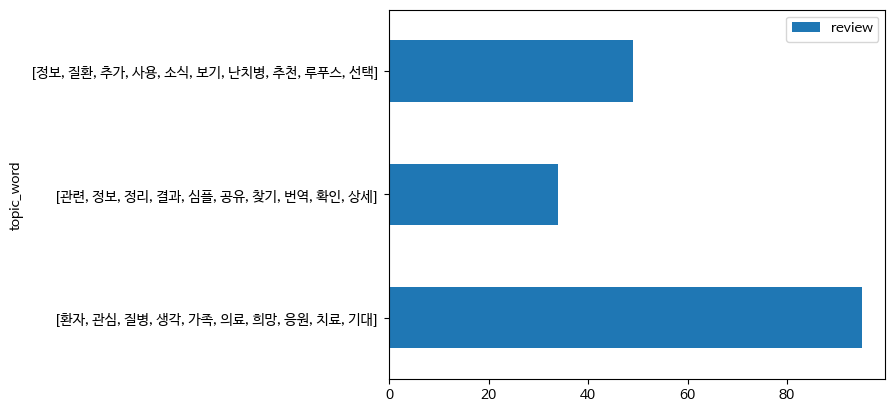

In [359]:
visual_table.index = visual_table['topic_word']
visual_table.plot.barh()
plt.show()